In [ ]:
import sys
from netCDF4 import Dataset
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
#from trackeddy.plotfunc import *
from numpy import *
from pylab import *
import cmocean as cm
import random
%matplotlib inline
import scipy.optimize as opt

In [ ]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def moveGaussian(size,fwhm,center,timestep):
    z=zeros([timestep,size,size])
    for tt in range(0,timestep):
        z[tt,:,:]=makeGaussian(size, fwhm, (center[tt,0],center[tt,1]))
    return z

In [ ]:
x,y=linspace(-10,10,50),linspace(-10,10,50)
X,Y=meshgrid(x,y)
# Gaussian:
gaussian=twoD_Gaussian((X,Y,1,0,0),  2.5, 2.5, 0, 0, 0 , 0)
zz=gaussian.reshape(50,50)
# Checking fitting:
gausssianfitp,R2=fit2Dcurve(zz,(x,y,0.5,1,0),0,initial_guess='',\
                                date='',diagnostics=False)
gaussianfit=twoD_Gaussian((X,Y,1,0,0),*gausssianfitp)

In [ ]:
gausssianfitp

In [ ]:
contourf(x,y,zz[:,:])
colorbar()
figure()
contourf(x,y,gaussianfit.reshape(50,50),alpha=0.5)
colorbar()
print(abs(sum(zz)-sum(gausssianfitp)))

# Flat Background 

In [ ]:
zz=moveGaussian(600,70,array([[x,x*0+150] for x in linspace(100,400,40)]),40)+\
    moveGaussian(600,50,array([[x,x*0+350] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,50,array([[500-x,x*0+250] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,100,array([[500-x,x*0+450] for x in linspace(100,400,40)]),40)
    
lat=linspace(0,10,600)
lon=linspace(0,10,600)
pcolormesh(zz[0,:,:])
colorbar()

In [ ]:
eddytdp=analyseddyt(zz[:,:,:],lon,lat,0.2,0,40,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)
eddytdn=analyseddyt(zz[:,:,:],lon,lat,-0.2,0,40,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)

In [ ]:
fieldSp=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)
fieldSn=reconstruct_syntetic(shape(zz),lon,lat,eddytdn)
fieldS=fieldSp+fieldSn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

rtext=[]
for ii in range(0,40):
    rtext.append(rsquard(sum(zz[ii,:,:],axis=1),sum(fieldS[ii,:,:],axis=1)))

fig = plt.figure(figsize=(12, 3),facecolor='white')
gs = gridspec.GridSpec(1, 4)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(lon,lat,fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(lon,lat,zz[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb2 = fig.colorbar(quad2,ax=ax2)

ax3 = plt.subplot(gs[0,2])

quad3 = ax3.pcolormesh(lon,lat,zz[0,:,:]-fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb3 = fig.colorbar(quad3,ax=ax3)

ax4=plt.subplot(gs[0,3])

line4a, =ax4.plot(lat,sum(zz[0,:,:],axis=1),'-r')
line4b, =ax4.plot(lat,sum(fieldS[0,:,:],axis=1),'-b')
text4 = ax4.text(mean(lat),100,'')
ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    quad3.set_array([])
    line4a.set_data([], [])
    line4b.set_data([], [])
    text4.set_text('')
    return quad1,quad2,quad3,line4a,line4b,text4
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(fieldS[iter,:,:].ravel())
    quad2.set_array(zz[iter,:,:].ravel())
    quad3.set_array(zz[iter,:,:].ravel()-fieldS[iter,:,:].ravel())
    line4a.set_data(lat,sum(zz[iter,:,:],axis=1))
    line4b.set_data(lat,sum(fieldS[iter,:,:],axis=1))
    text4.set_text(r'r^2 = %.2f' % rtext[iter])
    return quad1,quad2,quad3,line4a,line4b
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=40,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2

In [ ]:
plot(sum(fieldS[20,:,:],axis=1),'-r')
plot(sum(zz[20,:,:],axis=1),'-b')

# Background slope

In [ ]:
zz1=ones([600,600])*linspace(0.2,0,600)
zzz=moveGaussian(600,70,array([[x,x*0+150] for x in linspace(100,400,40)]),40)+\
    moveGaussian(600,50,array([[x,x*0+350] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,50,array([[500-x,x*0+250] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,100,array([[500-x,x*0+450] for x in linspace(100,400,40)]),40)
zz=zz1+zzz

lat=linspace(0,10,600)
lon=linspace(0,10,600)
pcolormesh(zz[0,:,:])

In [ ]:
eddytdp=analyseddyt(zz[:,:,:],lon,lat,0.25,0,40,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)
eddytdn=analyseddyt(zz[:,:,:],lon,lat,-0.25,0,40,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)

In [ ]:
fieldSp=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)
fieldSn=reconstruct_syntetic(shape(zz),lon,lat,eddytdn)
fieldS=fieldSp+fieldSn

In [ ]:
pcolormesh(zz[0,:,:]-zz1)
colorbar()
show()
pcolormesh(fieldS[0,:,:])
colorbar()
show()
pcolormesh(zz[0,:,:]-zz1-fieldS[0,:,:])
colorbar()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

rtext=[]
for ii in range(0,40):
    rtext.append(rsquard(sum(zzz[ii,:,:],axis=1),sum(fieldS[ii,:,:],axis=1)))

fig = plt.figure(figsize=(12, 3),facecolor='white')
gs = gridspec.GridSpec(1, 4)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(lon,lat,fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(lon,lat,zzz[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb2 = fig.colorbar(quad2,ax=ax2)

ax3 = plt.subplot(gs[0,2])

quad3 = ax3.pcolormesh(lon,lat,zzz[0,:,:]-fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-0.1,vmax=0.1)
cb3 = fig.colorbar(quad3,ax=ax3)

ax4=plt.subplot(gs[0,3])

line4a, =ax4.plot(lat,sum(zzz[0,:,:],axis=1),'-r')
line4b, =ax4.plot(lat,sum(fieldS[0,:,:],axis=1),'-b')
text4 = ax4.text(mean(lat),100,'')
ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    quad3.set_array([])
    line4a.set_data([], [])
    line4b.set_data([], [])
    text4.set_text('')
    return quad1,quad2,quad3,line4a,line4b,text4
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(fieldS[iter,:,:].ravel())
    quad2.set_array(zzz[iter,:,:].ravel())
    quad3.set_array(zzz[iter,:,:].ravel()-fieldS[iter,:,:].ravel())
    line4a.set_data(lat,sum(zzz[iter,:,:],axis=1))
    line4b.set_data(lat,sum(fieldS[iter,:,:],axis=1))
    text4.set_text(r'r^2 = %.2f' % rtext[iter])
    return quad1,quad2,quad3,line4a,line4b
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=40,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2

# Simple Sinusoidal Background

In [ ]:
zz1=ones([600,600])*0.2*sin(linspace(1,4*pi,600))
zzz=moveGaussian(600,70,array([[x,x*0+150] for x in linspace(100,400,40)]),40)+\
    moveGaussian(600,50,array([[x,x*0+350] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,50,array([[500-x,x*0+250] for x in linspace(100,400,40)]),40)-\
    moveGaussian(600,100,array([[500-x,x*0+450] for x in linspace(100,400,40)]),40)
zz=zz1+zzz

lat=linspace(0,10,600)
lon=linspace(0,10,600)
pcolormesh(zz[0,:,:])

In [ ]:
eddytdp=analyseddyt(zz[:,:,:],lon,lat,0.3,0,40,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)
eddytdn=analyseddyt(zz[:,:,:],lon,lat,-0.3,0,40,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',gaussrsquarefit=0,\
                    checkgauss=True,diagnostics=False,pprint=False)

In [ ]:
fieldSp=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)
fieldSn=reconstruct_syntetic(shape(zz),lon,lat,eddytdn)
fieldS=fieldSp+fieldSn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

rtext=[]
for ii in range(0,40):
    rtext.append(rsquard(sum(zzz[ii,:,:],axis=1),sum(fieldS[ii,:,:],axis=1)))

fig = plt.figure(figsize=(12, 3),facecolor='white')
gs = gridspec.GridSpec(1, 4)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(lon,lat,fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(lon,lat,zzz[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb2 = fig.colorbar(quad2,ax=ax2)

ax3 = plt.subplot(gs[0,2])

quad3 = ax3.pcolormesh(lon,lat,zzz[0,:,:]-fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance)
cb3 = fig.colorbar(quad3,ax=ax3)

ax4=plt.subplot(gs[0,3])

line4a, =ax4.plot(lat,sum(zzz[0,:,:],axis=1),'-r')
line4b, =ax4.plot(lat,sum(fieldS[0,:,:],axis=1),'-b')
text4 = ax4.text(mean(lat),100,'')
ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    quad3.set_array([])
    line4a.set_data([], [])
    line4b.set_data([], [])
    text4.set_text('')
    return quad1,quad2,quad3,line4a,line4b,text4
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(fieldS[iter,:,:].ravel())
    quad2.set_array(zzz[iter,:,:].ravel())
    quad3.set_array(zzz[iter,:,:].ravel()-fieldS[iter,:,:].ravel())
    line4a.set_data(lat,sum(zzz[iter,:,:],axis=1))
    line4b.set_data(lat,sum(fieldS[iter,:,:],axis=1))
    text4.set_text(r'r^2 = %.2f' % rtext[iter])
    return quad1,quad2,quad3,line4a,line4b
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=40,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2

In [ ]:
from random import randrange, uniform

def moveGaussian(size,fwhm,center,timestep):
    z=zeros([timestep,size,size])
    for tt in range(0,timestep):
        z[tt,:,:]=makeGaussian(size, fwhm, (center[tt,0],center[tt,1]))
    return z

def RandGaussian(size,time,nn):
    zz=zeros([time,size,size])
    zz1=zz*1
    ii=0
    while ii < nn:
        xx=(randrange(0, 100)/100.0)*size
        xxx=(randrange(0, 100)/100.0)*size
        yyy=(randrange(0, 100)/100.0)*size
        if xx > size/8 and xx < size/4:
            center=array([[xxx,yyy+x] for x in linspace(size*0.1,size*0.9,time)])
            #print(center)
            for tt in range(0,time):
                zz1[tt,:,:]=makeGaussian(size, xx,(center[tt,0],center[tt,1]))
            zz=zz+zz1
            ii=ii+1
    return zz

In [ ]:
size=600
time=40
zzn=-RandGaussian(size,time,10)
zzp=RandGaussian(size,time,10)

zz=zzn+zzp

lat=linspace(0,10,600)
lon=linspace(0,10,600)

pcolormesh(lon,lat,zz[0,:,:])
colorbar()

In [ ]:
eddytdp=analyseddyt(zz[:,:,:],lon,lat,0.8,0,1,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)
eddytdn=analyseddyt(zz[:,:,:],lon,lat,-0.8,0,1,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)

In [ ]:
def reconstruct_syntetic(varshape,lon,lat,eddytd):
    Lon,Lat=meshgrid(lon,lat)
    fieldfit=np.zeros(varshape)
    for key in eddytd.keys():
        for tt in range(0,len(eddytd[key]['2dgaussianfit'])):
            gaussfit=eddytd[key]['2dgaussianfit'][tt]
            gaussian=twoD_Gaussian((Lon,Lat,eddytd[key]['position_maxvalue'][0][2],\
                         eddytd[key]['position_maxvalue'][0][0],\
                         eddytd[key]['position_maxvalue'][0][1]), *gaussfit)
            fieldfit[tt,:,:]=fieldfit[tt,:,:]+gaussian.reshape(len(lat),len(lon))
    return fieldfit

In [ ]:
Lon,Lat=meshgrid(lon,lat)
gaussfit=eddytdp['eddyn_1']['2dgaussianfit'][0]
print(gaussfit)
gaussian=twoD_Gaussian((Lon,Lat,eddytdp['eddyn_1']['position_maxvalue'][0][2],\
                         eddytdp['eddyn_1']['position_maxvalue'][0][0],\
                         eddytdp['eddyn_1']['position_maxvalue'][0][1]),*gaussfit)
pcolormesh(lon,lat,gaussian.reshape(600,600))

In [ ]:
sfield=reconstruct_syntetic(shape(zz),lon,lat,eddytdp)
nfield=reconstruct_syntetic(shape(zz),lon,lat,eddytdn)

pcolormesh(lon,lat,sfield[0,:,:]+nfield[0,:,:])
colorbar()
figure()
pcolormesh(lon,lat,zz[0,:,:])
colorbar()

# Random Walker

In [1]:
import sys
from netCDF4 import Dataset
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
#from trackeddy.plotfunc import *
from numpy import *
from pylab import *
import cmocean as cm
import random
%matplotlib inline
import scipy.optimize as opt

In [2]:
def go_right(indexs,step):
    return [0,step]
    
def go_upright(indexs,step):
    return [step,step]
    
def go_up(indexs,step):
    return [step,0]

def go_upleft(indexs,step):
    return [step,-step]
    
def go_left(indexs,step):
    return [0,-step]

def go_downleft(indexs,step):
    return [-step,-step]
    
def go_down(indexs,step):
    return [-step,0]

def go_downright(indexs,step):
    return [-step,step]

In [3]:
from random import randrange, uniform
import numpy as np

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def moveGaussian(size,fwhm,center,timestep):
    z=np.zeros([timestep,size,size])
    for tt in range(0,timestep):
        z[tt,:,:]=makeGaussian(size, fwhm, (center[tt,0],center[tt,1]))
    return z

def RandGaussian(size,time,nn):
    zz=np.zeros([time,size,size])
    zz1=zz*1
    ii=0
    while ii < nn:
        xx=(randrange(0, 100)/100.0)*size
        xxx=(randrange(0, 100)/100.0)*size
        yyy=(randrange(0, 100)/100.0)*size
        if xx > size/8 and xx < size/4:
            center=array([[xxx,yyy+x] for x in linspace(size*0.1,size*0.9,time)])
            #print(center)
            for tt in range(0,time):
                zz1[tt,:,:]=makeGaussian(size, xx,(center[tt,0],center[tt,1]))
            zz=zz+zz1
            ii=ii+1
    return zz

In [4]:
size=600
time=1
zzn=-RandGaussian(size,time,10)
zzp=RandGaussian(size,time,10)

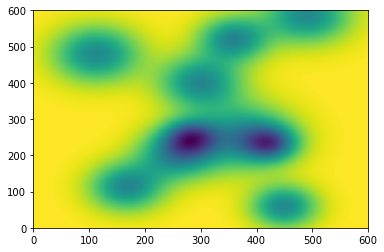

In [5]:
plt.pcolormesh(zzn[0,:,:])

In [6]:
x=linspace(0,1,100)
y=linspace(0,1,100)
X,Y=meshgrid(x,y)
gauss=twoD_Gaussian((X,Y,1,0.5,0.5), 0.1, 0.1, 0, slopex=0, slopey=0, offset=0).reshape(len(x),len(y))


In [28]:
def dist(loc1,loc2):
    return sqrt((loc1[0]-loc2[0])**2 + (loc2[1]-loc1[1])**2)

n=7
steps=1
x=linspace(0,1,100)
y=linspace(0,1,100)

xlen=len(x)
ylen=len(y)

count=0

X,Y=meshgrid(x,y)
a=b=0.1
count=a
data=zeros(shape(X))
diagnostics=True
rmlist=[]

eddies={'eddy_n%s' % ii:{'loc':[[randint(0,xlen), randint(0,ylen)]],'grow':True,'radius':a,\
                         'amp':random.choice([-1,1])} for ii in range(n)}
#print(eddies)
def checkposition(eddies,x,y,):
    for key,item in eddies.items():
        for key1,item1 in eddies.items():
            xc=item['loc'][0][0]
            yc=item['loc'][0][1]
            xc1=item1['loc'][0][0]
            yc1=item1['loc'][0][1]
            distance=dist([x[xc],y[yc]],[x[xc1],y[yc1]])
            #print(distance)
            checker = (distance < 1*a or distance < 1*b ) and key1!=key
            #print(checker)
            while checker:
                newx=randint(0,xlen)
                newy=randint(0,ylen)
                eddies[key1]={'loc':[[newx, newy]],'grow':True,'radius':a,\
                             'amp':random.choice([-1,1])}
                xc1=newx
                yc1=newy
                distance=dist([x[xc],y[yc]],[x[xc1],y[yc1]])
                checker = (distance < 1*a or distance < 1*b ) and key1!=key

In [29]:
checkposition(eddies,x,y)

In [30]:
data=zeros(shape(X))
for keys, item in eddies.items():
    gauss=twoD_Gaussian((X,Y,item['amp'],x[item['loc'][0][0]],y[item['loc'][0][1]]),\
                        item['radius'], item['radius'], 0, slopex=0, slopey=0, offset=0).reshape(shape(X))
    data=data+gauss

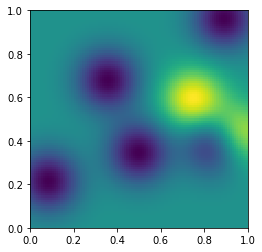

In [31]:
pcolormesh(x,y,data)
plt.gca().set_aspect('equal', adjustable='box')

In [32]:
def make_random_walk(indexs, steps):
    move_dict = {1: go_up,
                 2: go_right,
                 3: go_left,
                 4: go_down,
                 5: go_downleft,
                 6: go_downright,
                 7: go_upleft,
                 8: go_upright,
                 }
    for _ in range(steps):
        for ii in indexs:
            move_in_a_direction = move_dict[random.randint(1, 8)]
            movcood=move_in_a_direction(ii,5)
    return indexs[0]+movcood[0],indexs[1]+movcood[1]

In [33]:
time=1
moving=True
count=0
while time <= 40:
    #print(item['loc'])
    [item['loc'].append(list(make_random_walk([item['loc'][time-1][0],item['loc'][time-1][1]],1))) for key,item in eddies.items()]
    #print(item['loc'])
    #item['loc'].append(list(make_random_walk([item['loc'][time-1][0],item['loc'][time-1][1]],1)))
    time=time+1

In [34]:
x=linspace(-1,2,300)
y=linspace(-1,2,300)
data=zeros((40,len(x),len(y)))
X,Y=meshgrid(x,y)
for t in range(40):
    for keys, item in eddies.items():
        gauss=twoD_Gaussian((X,Y,item['amp'],x[item['loc'][t][0]+100],y[item['loc'][t][1]+100]),\
                        item['radius'], item['radius'], 0, slopex=0, slopey=0, offset=0).reshape(shape(X))
        data[t,:,:]=data[t,:,:]+gauss

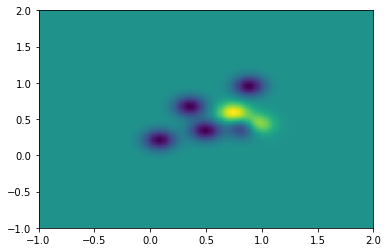

In [35]:
pcolormesh(x,y,data[0,:,:])

In [36]:
eddytdn=analyseddyzt(data,x,y,0,40,1,-0.5,-0.01,-0.01\
                    ,data_meant='',areamap='',mask=''\
                    ,destdir='',physics='',diagnostics=False,plotdata=False,pprint=False)

 0% [====================>]100% | Elapsed Time:0 s | Estimated Time:0 s | Info: Init time |
 0% [====================>]100% | Elapsed Time:2046 s | Estimated Time:2046 s | Info: 86 |


In [37]:
eddytd=analyseddyzt(data,x,y,0,40,1,0.5,0.01,0.01\
                    ,data_meant='',areamap='',mask=''\
                    ,destdir='',physics='',diagnostics=False,plotdata=False,pprint=False)

 0% [====================>]100% | Elapsed Time:0 s | Estimated Time:0 s | Info: Init time |
 0% [====================>]100% | Elapsed Time:1627 s | Estimated Time:1627 s | Info: 70 |


In [38]:
syntetic_gaussian=reconstruct_syntetic(shape(data),x,y,eddytd)+reconstruct_syntetic(shape(data),x,y,eddytdn)

 0% [====================>]100% | Elapsed Time:1 s | Estimated Time:1 s | Info: eddyn_1 |
 0% [====================>]100% | Elapsed Time:0 s | Estimated Time:0 s | Info: eddyn_7 |


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

fig = plt.figure(figsize=(6, 3),facecolor='white')
gs = gridspec.GridSpec(1, 2)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(x,y,data[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(x,y,syntetic_gaussian[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)


#line4a, =ax4.plot(lat,sum(zzz[0,:,:],axis=1),'-r')
#ax4.set_ylim([-150,150])

##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    #line4a.set_data([], [])
    #line4b.set_data([], [])
    #text4.set_text('')
    return quad1,quad2
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(data[iter,:,:].ravel())
    quad2.set_array(syntetic_gaussian[iter,:,:].ravel())
    
    #line4a.set_data(lat,sum(zzz[iter,:,:],axis=1))
    return quad1,quad2
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=40,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2

In [ ]:


while steps != 0:
    
    amp=randint(-1,1)
    amp=-1
    if amp!=0:
        count=a
        for xc,yy in loc:

            gauss=twoD_Gaussian((X,Y,amp,x[xc],y[yc]), count, count, 0, slopex=0, slopey=0, offset=0).reshape(shape(X))

            if x[xc]+(2*count) >= x.max() or x[xc]-(2*count) <= x.min() or y[yc]+(2*count) >= y.max() or y[yc]-(2*count) <= y.min():
                data=data+gauss
                steps=steps-1
            else:
                count=count+a
        if diagnostics == True:
            pcolormesh(x,y,data)
            plot(x[xc],y[yc],'*r')
            plot([x[xc]-2*count,x[xc]+2*count],[y[yc],y[yc]],'-k')
            plot([x[xc],x[xc]],[y[yc]-2*count,y[yc]+2*count],'-g')
            colorbar()
            show()